# Step #1 Load the Data

In [1]:
# Remote data access for pandas
import pandas_datareader as webreader
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.colors as col 
import matplotlib.cm as cm 
import numpy as np 
from math import log, exp 
from datetime import date, timedelta, datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit

# Getting Bitcoin price data from 2014-09-16 until today
date_today = date.today().strftime("%Y-%m-%d")
date_start = '2012-09-16'
stockname = 'BTC-USD'
symbol = 'BTC-USD'
df1 = webreader.DataReader(symbol, start=date_start, end=date_today, data_source="yahoo")
df1_close = df1.filter(['Close'])

# Load price data earlier than 2014-09-16 from a local CSV file 
df2 = pd.read_csv('C:/Users/Flo/relataly-python-tutorials/data/CryptoPrices/bitcoin_price_daily_2010-2018.csv') 
df2_filter = df2.loc[(df2['btc_market_price'] > 0) & (df2['Date'] < '2014-09-16 00:00:00')]
Dates = pd.to_datetime(df2_filter['Date'], format='%Y-%m-%d', errors='ignore')
df2_close = df2_filter.set_index(Dates).filter(['btc_market_price']).rename(columns={"btc_market_price": "Close"})

# Concatenate the two datasets to get the full historic Bitcoin price range starting from 2010-08-17
df = pd.concat([df2_close, df1_close])
df

,Close
Date,
2010-08-17,0.076900
2010-08-18,0.074000
2010-08-19,0.068800
2010-08-20,0.066700
2010-08-21,0.066899
...,...
2021-06-19,35698.296875
2021-06-20,31676.693359
2021-06-21,32505.660156


# Step #2 Fit the Logarithmic Regression Curve

In [2]:
# this function converts a given set of indicator values to colors
def get_colors(ind, colormap):
    norm = col.Normalize(vmin=ind.min(), vmax=ind.max())
    colorlist = [list(colormap(norm(i))) for i in ind]
    return colorlist

# this function defines the basic logarithmic function that is fit to the data
def func(x, a, b, c):
    return a*np.log(x + c) + b 

x = [x for x in range(1, len(df) + 1)]
y = np.log(np.array(df['Close']))
popt, pcov = curve_fit(func, x, y)
df['log_curve'] =  func(np.array([x for x in range(len(df))]), *popt)

# we restrict the timeframe to those values for which we have positive log curve values
df = df.loc[(df['log_curve'] > 0)].copy()

# Step #3 Calculate the Risk-Level and Turn it into Color Codes

In [3]:
# calculate the risk level by diving the closing price through the logarithmic curve
df['risk_level'] = np.log(df['Close'] / df['log_curve'])
y = df['risk_level']

# convert to Colormap     
cmap = plt.get_cmap('plasma')
df['risk_level_colors'] = get_colors(y, cmap)

# Step #4 Print Logarithmic Bitcoin Price Chart Color-Coded by Risk Level

NameError: name 'halving_dates' is not defined

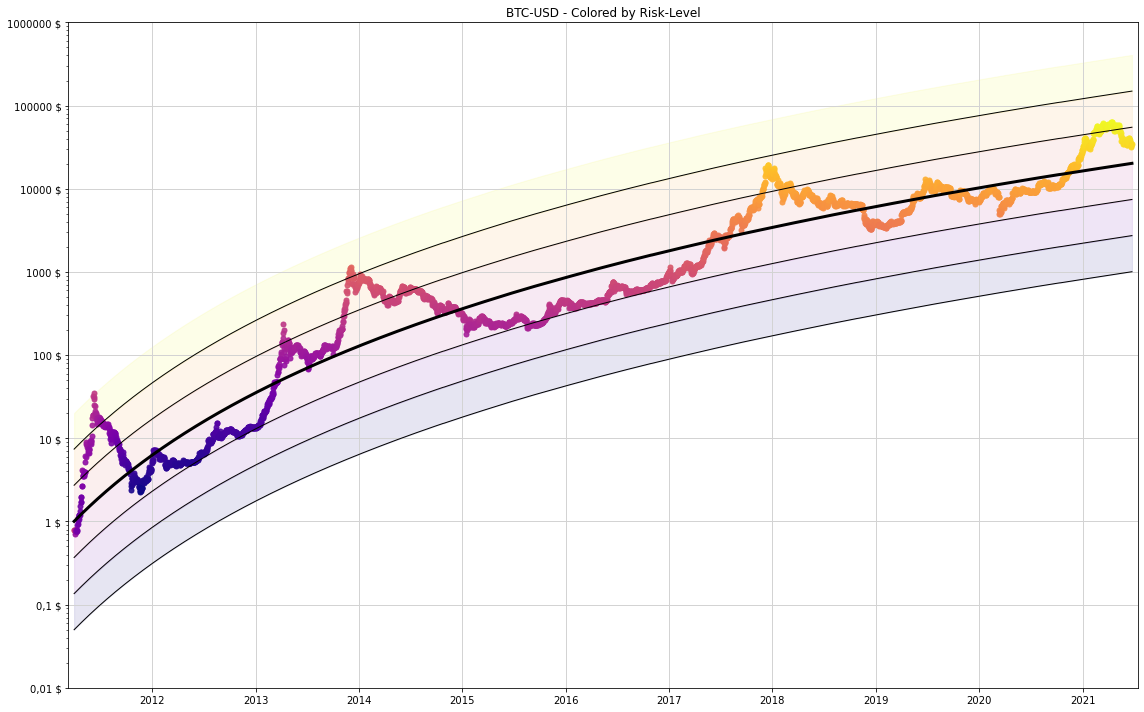

In [4]:
# function that plots the color bar next to the chart
def defineBar(s, ax, cmap):
    vmin= s.min()
    vmax = s.max()
    m = cm.ScalarMappable(cmap=cmap, norm=col.Normalize(vmin=vmin,vmax=vmax))
    m.set_array([(x-vmin)/(vmax-vmin) for x in s.values])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    return cax, m

# function that plots color-coded values 
def draw_points(ax, y, z):
    # draw points
    for i in range(len(df)):
        ax.plot(x[i], np.array(y[i]), 'o',  color=z[i], alpha = 0.9, markersize=5)

# setup the data for the price chart
pd.plotting.register_matplotlib_converters()
fig, ax = plt.subplots(figsize=(16, 10), sharex=False)

# plot the color-coded price points
x = df.index
y = df['Close']
z = df['risk_level_colors']
w = df['log_curve']
draw_points(ax, y, z)
bandrange = range(-2, 4)
colors = iter(plt.get_cmap('plasma')(np.linspace(0, 1, len(bandrange))))

# plot the log regression line
for i in bandrange:
    plt.plot(x, np.exp(w + i - 1), color='black', linewidth=1)
    plt.fill_between(x, np.exp(w + i - 1), np.exp(w + i), alpha=0.1, color=next(colors))
plt.plot(x, np.exp(w), color='black', linewidth=3)

# customize the price chart
ax.tick_params(axis='y', labelcolor='black')
plt.xlim([min(x) - timedelta(days=20), max(x) + timedelta(days=20)])
plt.ylim(0.01, 1000000)
plt.title('BTC-USD - Colored by Risk-Level')
plt.yscale('log')
plt.yticks([0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000], ['0,01 $', '0,1 $', '1 $', '10 $', '100 $', '1000 $', '10000 $', '100000 $', '1000000 $'])
plt.grid(color='lightgrey', linestyle='-', linewidth=1)
plt.tight_layout()

# add halving dates as vertical lines to the price chart
for s in halving_dates:
    plt.axvline(x=datetime.strptime(s, '%Y-%m-%d').date(), color = 'black', linewidth=2, linestyle='dashed')

# plot the color bar
cax, m = defineBar(df['risk_level'], ax, 'plasma')
fig.colorbar(m, cax=cax)
plt.show()